In [1]:
import os
import re
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

from xgboost import XGBClassifier, XGBRegressor

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
DATA_PATH = 'Data/'
for filename in sorted(os.listdir(DATA_PATH)):
    print(filename)

2024_gt.csv
2024_test.csv
2024_test_R2.csv
2024_test_r3.csv
2024_test_r4.csv
2024_test_r5.csv
2024_test_r6.csv
2024_tourney_seeds.csv
538ratingsMen.csv
538ratingsWomen.csv
Cities.csv
Conferences.csv
EloRating_mens_10.csv
EloRating_womens_10.csv
MConferenceTourneyGames.csv
MGameCities.csv
MMasseyOrdinals_thruSeason2024_day128.csv
MNCAATourneyCompactResults.csv
MNCAATourneyDetailedResults.csv
MNCAATourneySeedRoundSlots.csv
MNCAATourneySeeds.csv
MNCAATourneySlots.csv
MRegularSeasonCompactResults.csv
MRegularSeasonDetailedResults.csv
MSeasons.csv
MSecondaryTourneyCompactResults.csv
MSecondaryTourneyTeams.csv
MTeamCoaches.csv
MTeamConferences.csv
MTeamSpellings.csv
MTeams.csv
SampleSubmission2023.csv
WGameCities.csv
WNCAATourneyCompactResults.csv
WNCAATourneyDetailedResults.csv
WNCAATourneySeeds.csv
WNCAATourneySlots.csv
WRegularSeasonCompactResults.csv
WRegularSeasonDetailedResults.csv
WSeasons.csv
WTeamConferences.csv
WTeamSpellings.csv
WTeams.csv
advanced_metrics.csv
features_mens.csv
fe

# Data Loading

In [3]:
df_seeds = pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv")

df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


 For each season, the file includes all games played from DayNum 0 through 132. It is important to realize that the "Regular Season" games are simply defined to be all games played on DayNum=132 or earlier (DayNum=132 is Selection Sunday, and there are always a few conference tournament finals actually played early in the day on Selection Sunday itself). Thus a game played on or before Selection Sunday will show up here whether it was a pre-season tournament, a non-conference game, a regular conference game, a conference tournament game, or whatever.

In [4]:
df_season_results = pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv")

df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [5]:
df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']

In [6]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,ScoreGap
0,2003,10,1104,68,1328,62,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,6


# Features

Compute:


*   Number of Wins and Losses
*   Avg Score Gap in Wins and Losses
*   Points scored in Wins and Losses
*   Field Goal Percentage
*   Number of Two-pointers and three-pointers made
*   Number of free throws attempted and made
*   Turnovers and Assists per game

To Derive the Following Features:

*  Effective Field Goal Percentage
*  True Shooting Percentage
*  Margin of Victory
*  Pythagorean Wins/Losses
*  Assist/Turnover Ratio
*  Defensive Rating



In [7]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,ScoreGap
0,2003,10,1104,68,1328,62,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,6


In [8]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

In [9]:
pts_win = df_season_results.groupby(['Season', 'WTeamID']).sum()
pts_win = pts_win.reset_index()[['Season', 'WTeamID', "WScore", "LScore"]].rename(columns={"WScore": "WTotalPoints", "WTeamID": "TeamID", "LScore": "LPointsAgainst"})

In [10]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

In [11]:
pts_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
pts_loss = pts_loss.reset_index()[['Season', 'LTeamID', 'LScore', "WScore"]].rename(columns={"LScore": "LTotalPoints", "LTeamID": "TeamID", "WScore": "WPointsAgainst"})

In [12]:
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

In [13]:
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

In [14]:
df_wefg = df_season_results.groupby(['Season', 'WTeamID']).sum()
df_wefg = df_wefg.reset_index()[['Season', 'WTeamID', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3']].rename(columns={"WTeamID": "TeamID"})

In [15]:
df_lefg = df_season_results.groupby(['Season', 'LTeamID']).sum()
df_lefg = df_lefg.reset_index()[['Season', 'LTeamID', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3']].rename(columns={"LTeamID": "TeamID"})

In [16]:
wts = df_season_results.groupby(['Season', 'WTeamID']).sum()
wts = wts.reset_index()[['Season', 'WTeamID', 'WScore', 'WFTA']].rename(columns={"WTeamID":"TeamID"})

In [17]:
lts = df_season_results.groupby(['Season', 'LTeamID']).sum()
lts = lts.reset_index()[['Season', 'LTeamID', 'LScore', 'LFTA']].rename(columns={"LTeamID": "TeamID"})

In [18]:
watv = df_season_results.groupby(['Season', 'WTeamID']).sum()
watv = watv.reset_index()[['Season', 'WTeamID', 'WAst', 'WTO']].rename(columns={"WTeamID": "TeamID"})

In [19]:
latv = df_season_results.groupby(['Season', 'LTeamID']).sum()
latv = latv.reset_index()[['Season', 'LTeamID', 'LAst', 'LTO']].rename(columns={"LTeamID": "TeamID"})

In [20]:
wrb = df_season_results.groupby(['Season', 'WTeamID']).sum()
wrb = wrb.reset_index()[['Season', 'WTeamID', 'WOR']].rename(columns={"WTeamID":"TeamID"})

In [21]:
lrb = df_season_results.groupby(['Season', 'LTeamID']).sum()
lrb = lrb.reset_index()[['Season', 'LTeamID', 'LOR']].rename(columns={"LTeamID":"TeamID"})

In [22]:
wagainst = df_season_results.groupby(['Season', 'WTeamID']).sum()
wagainst = wagainst.reset_index()[['Season', 'WTeamID', 'LFGA', 'LFTA', 'LOR', 'LTO']].rename(columns={"WTeamID":"TeamID", "LFGA":"WFGAopp", "LFTA":"WFTAopp", "LOR":"WORopp", "LTO":"WTOopp"})

In [23]:
lagainst = df_season_results.groupby(['Season', 'LTeamID']).sum()
lagainst = lagainst.reset_index()[['Season', 'LTeamID', 'WFGA', 'WFTA', 'WOR', 'WTO']].rename(columns={'LTeamID':"TeamID", 'WFGA':'LFGAopp', 'WFTA': 'LFTAopp', 'WOR': 'LORopp', 'WTO':'LTOopp'})

In [24]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [25]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [26]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(pts_win, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(pts_loss, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(df_wefg, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(df_lefg, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(wts, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(lts, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(watv, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(latv, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(wrb, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(lrb, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(wagainst, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(lagainst, on=["Season", 'TeamID'], how="left")

In [27]:
df_features_season.fillna(0, inplace=True)

In [28]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] -
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

In [29]:
df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)

In [30]:
df_features_season['PointsFor'] = df_features_season['WTotalPoints'] + df_features_season['LTotalPoints']
df_features_season['PointsAgainst'] = df_features_season['LPointsAgainst'] + df_features_season["WPointsAgainst"]

In [31]:
df_features_season.drop(['WTotalPoints', 'LTotalPoints', 'LPointsAgainst', 'WPointsAgainst'], axis=1, inplace=True)

In [32]:
# https://captaincalculator.com/sports/basketball/pythagorean-win-percentage-calculator/
# Pythagorean win pct
# Using the Daryl Morey exponent
exp = 13.91
df_features_season["PyWinPct"] = df_features_season['PointsFor']**exp / ((df_features_season['PointsFor']**exp)+(df_features_season['PointsAgainst']**exp))

In [33]:
# Effective Field Goal Percentage
# https://www.breakthroughbasketball.com/stats/effective-field-goal-percentage.html

df_features_season['2PFGM'] = df_features_season['WFGM'] + df_features_season['LFGM'] - df_features_season['WFGM3'] -df_features_season['LFGM3']
df_features_season["FGA"] = df_features_season['WFGA'] + df_features_season['LFGA']
df_features_season['3PFGM'] = df_features_season['WFGA3'] + df_features_season['WFGA3']

df_features_season["EFG"] = (df_features_season["2PFGM"] + 1.5 * df_features_season["3PFGM"]) / df_features_season["FGA"]
df_features_season.drop(['2PFGM', '3PFGM'], axis=1, inplace=True)


In [34]:
# True Shooting Percentage
# https://www.breakthroughbasketball.com/stats/tsp_calc.html
df_features_season["TS"] = (
    (df_features_season['WScore'] + df_features_season['LScore']) /
    (2 *
    (df_features_season['FGA'] + 0.44 * (df_features_season['LFTA'] + df_features_season['WFTA'])))
)

In [35]:
# Assist Turnover Ratio
# https://captaincalculator.com/sports/basketball/assist-turnover-ratio-calculator/
df_features_season["ATR"] = (df_features_season['WAst']+df_features_season['LAst'])/(df_features_season['LTO']+df_features_season['WTO'])

In [36]:
# Defensive Rating
# https://www.fromtherumbleseat.com/pages/advanced-basketball-statistics-formula-sheet
df_features_season["ORB"] = df_features_season['WOR'] + df_features_season['LOR']
df_features_season['TOV'] = df_features_season['WTO'] + df_features_season['LTO']
df_features_season["TmPos"] = 0.5 * (df_features_season['FGA'] + 0.475 * (df_features_season['LFTA'] + df_features_season['WFTA']) - df_features_season['ORB'] + df_features_season['TOV'])


In [37]:
df_features_season["ORBopp"] = df_features_season['WORopp'] + df_features_season['LORopp']
df_features_season['TOVopp'] = df_features_season['WTOopp'] + df_features_season['LTOopp']
df_features_season["FGAopp"] = df_features_season['LFGAopp'] + df_features_season['WFGAopp']
df_features_season['FTAopp'] = df_features_season['LFTAopp'] + df_features_season['WFTAopp']
df_features_season['OppPos'] = 0.5*(df_features_season['FGAopp']+ (0.475*df_features_season['FTAopp']) - df_features_season['ORBopp'] + df_features_season['TOVopp'])

In [38]:
df_features_season["DRTG"] =  (100/(df_features_season["TmPos"]+df_features_season["OppPos"]))*df_features_season["PointsAgainst"]

In [39]:
df_features_season.drop(['WOR', 'LOR', 'ORB', 'TOV', 'TmPos', 'OppPos', 'ORBopp', 'TOVopp', 'FGAopp', 'FTAopp'], axis =1, inplace=True)

In [40]:
df_features_season.drop(['WORopp', 'LORopp', 'WTOopp', 'LTOopp', 'LFGAopp', 'WFGAopp', 'WFTAopp', 'LFTAopp'], axis=1, inplace=True)

In [41]:
df_features_season.drop(['PointsFor', 'PointsAgainst'], axis=1, inplace=True)

In [42]:
df_features_season.drop(['WFGM', 'WFGA', "WFGM3", "WFGA3", 'LFGM', 'LFGA', "LFGM3", "LFGA3", "FGA", "WScore", "LScore", "LFTA", "WFGA", "WFTA", 'WAst', 'LAst', 'WTO', 'LTO'], axis=1, inplace=True)

In [43]:
# Filter to include years 2016 and beyond
df_features_season = df_features_season[df_features_season['Season'] >= 2016]

In [44]:
df_seeds = df_seeds[df_seeds["Season"] >= 2016]
df_seeds["Seed"] = df_seeds["Seed"].apply(lambda x: int(re.sub(r"\D", "", x)))
df_seeds.head()

,Season,Seed,TeamID
2014,2016,1,1314
2015,2016,2,1462
2016,2016,3,1452
2017,2016,4,1246
2018,2016,5,1231


In [45]:
# add seed to teamid and season
df_features_season = df_seeds.merge(df_features_season, on=["Season", "TeamID"], how="left")

In [46]:
df_features_season.head()

,Season,Seed,TeamID,WinRatio,GapAvg,PyWinPct,EFG,TS,ATR,DRTG
0,2016,1,1314,0.823529,12.705882,0.950899,1.064472,0.560027,1.660377,79.506412
1,2016,2,1462,0.843750,10.312500,0.936886,1.173375,0.564868,1.284314,79.623559
2,2016,3,1452,0.764706,12.588235,0.976096,1.057073,0.546070,1.054622,69.010349
3,2016,4,1246,0.764706,11.411765,0.965513,1.054214,0.571307,1.310160,71.762854
4,2016,5,1231,0.781250,13.375000,0.972797,1.306867,0.615981,1.169336,74.844169


In [47]:
tourney_results = pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv")
tourney_results.drop(['WLoc', 'NumOT'], axis=1, inplace=True)
tourney_results = tourney_results[tourney_results['Season'] >= 2016]
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
1983,2016,134,1195,96,1192,65
1984,2016,134,1455,70,1435,50
1985,2016,135,1221,59,1380,55
1986,2016,135,1276,67,1409,62
1987,2016,136,1114,85,1345,83


In [48]:
tourney_results.drop(['DayNum','WScore','LScore'], axis=1,inplace=True)
print(tourney_results.shape)

(468, 3)


In [49]:
df_test = tourney_results
df_test['Pred'] = 0.5
# increment ID for df_test column
df_test['ID'] = df_test.index
df_test

,Season,WTeamID,LTeamID,Pred,ID
1983,2016,1195,1192,0.5,1983
1984,2016,1455,1435,0.5,1984
1985,2016,1221,1380,0.5,1985
1986,2016,1276,1409,0.5,1986
1987,2016,1114,1345,0.5,1987
...,...,...,...,...,...
2446,2023,1274,1400,0.5,2446
2447,2023,1361,1166,0.5,2447
2448,2023,1163,1274,0.5,2448
2449,2023,1361,1194,0.5,2449


In [50]:
# merge features for winning team, returns NaN for every entry, not working correctly
df_test = df_test.merge(df_features_season, left_on=["Season", "WTeamID"], right_on=["Season", "TeamID"], how="left")
# rename columns to W prefix
df_test.rename(columns={"Seed": "WSeed","WinRatio":"WWinRatio", "PyWinPct":"WPyWinPct", "GapAvg":"WGapAvg", "EFG":"WEFG", "TS":"WTS", "ATR":"WATR", "DRTG":"WDRTG"}, inplace=True)
# drop teamid column
df_test.drop("TeamID", axis=1, inplace=True)

# merge features for losing team, returns NaN for every entry, not working correctly
df_test = df_test.merge(df_features_season, left_on=["Season", "LTeamID"], right_on=["Season", "TeamID"], how="left")
# rename columns to L prefix
df_test.rename(columns={"Seed": "LSeed","WinRatio":"LWinRatio", "PyWinPct":"LPyWinPct", "GapAvg":"LGapAvg", "EFG":"LEFG", "TS":"LTS", "ATR":"LATR", "DRTG":"LDRTG"}, inplace=True)
# drop teamid column
df_test.drop("TeamID", axis=1, inplace=True)
df_test

,Season,WTeamID,LTeamID,Pred,ID,WSeed,WWinRatio,WGapAvg,WPyWinPct,WEFG,WTS,WATR,WDRTG,LSeed,LWinRatio,LGapAvg,LPyWinPct,LEFG,LTS,LATR,LDRTG
0,2016,1195,1192,0.5,1983,16,0.551724,2.724138,0.897271,0.786452,0.542317,1.074713,54.299848,16,0.548387,-1.677419,0.799285,0.903191,0.551992,1.084367,56.926712
1,2016,1455,1435,0.5,1984,11,0.741935,13.709677,0.987536,1.095265,0.541371,1.455738,63.152546,11,0.593750,9.406250,0.982146,0.987952,0.572964,1.278075,53.269416
2,2016,1221,1380,0.5,1985,16,0.424242,-4.333333,0.841737,0.778151,0.521186,1.267956,41.061483,16,0.612903,1.870968,0.885170,0.877585,0.527352,0.911681,57.246659
3,2016,1276,1409,0.5,1986,11,0.636364,6.242424,0.969639,1.115261,0.582399,1.538941,59.721301,11,0.645161,4.322581,0.911156,1.014501,0.543994,1.268657,60.318748
4,2016,1114,1345,0.5,1987,12,0.870968,9.935484,0.935576,1.213192,0.561699,1.261830,78.757438,5,0.764706,13.147059,0.978401,1.159091,0.578135,1.472906,69.765184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,0.5,2446,5,0.781250,7.281250,0.880799,1.161950,0.588282,1.365714,78.140444,2,0.764706,10.441176,0.961773,1.130010,0.567967,1.442667,66.380356
464,2023,1361,1166,0.5,2447,5,0.812500,7.531250,0.912279,1.172622,0.545244,1.194842,73.963932,6,0.636364,8.151515,0.963907,1.104992,0.579185,1.450276,57.842525
465,2023,1163,1274,0.5,2448,4,0.757576,13.424242,0.978436,1.251893,0.574027,1.400491,67.540952,5,0.781250,7.281250,0.880799,1.161950,0.588282,1.365714,78.140444
466,2023,1361,1194,0.5,2449,5,0.812500,7.531250,0.912279,1.172622,0.545244,1.194842,73.963932,9,0.906250,12.875000,0.950400,1.491348,0.580354,1.281690,82.578114


In [51]:
# decrease df test to only include rows that don't have nan's 
df_test = df_test.dropna()
df_test

,Season,WTeamID,LTeamID,Pred,ID,WSeed,WWinRatio,WGapAvg,WPyWinPct,WEFG,WTS,WATR,WDRTG,LSeed,LWinRatio,LGapAvg,LPyWinPct,LEFG,LTS,LATR,LDRTG
0,2016,1195,1192,0.5,1983,16,0.551724,2.724138,0.897271,0.786452,0.542317,1.074713,54.299848,16,0.548387,-1.677419,0.799285,0.903191,0.551992,1.084367,56.926712
1,2016,1455,1435,0.5,1984,11,0.741935,13.709677,0.987536,1.095265,0.541371,1.455738,63.152546,11,0.593750,9.406250,0.982146,0.987952,0.572964,1.278075,53.269416
2,2016,1221,1380,0.5,1985,16,0.424242,-4.333333,0.841737,0.778151,0.521186,1.267956,41.061483,16,0.612903,1.870968,0.885170,0.877585,0.527352,0.911681,57.246659
3,2016,1276,1409,0.5,1986,11,0.636364,6.242424,0.969639,1.115261,0.582399,1.538941,59.721301,11,0.645161,4.322581,0.911156,1.014501,0.543994,1.268657,60.318748
4,2016,1114,1345,0.5,1987,12,0.870968,9.935484,0.935576,1.213192,0.561699,1.261830,78.757438,5,0.764706,13.147059,0.978401,1.159091,0.578135,1.472906,69.765184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,0.5,2446,5,0.781250,7.281250,0.880799,1.161950,0.588282,1.365714,78.140444,2,0.764706,10.441176,0.961773,1.130010,0.567967,1.442667,66.380356
464,2023,1361,1166,0.5,2447,5,0.812500,7.531250,0.912279,1.172622,0.545244,1.194842,73.963932,6,0.636364,8.151515,0.963907,1.104992,0.579185,1.450276,57.842525
465,2023,1163,1274,0.5,2448,4,0.757576,13.424242,0.978436,1.251893,0.574027,1.400491,67.540952,5,0.781250,7.281250,0.880799,1.161950,0.588282,1.365714,78.140444
466,2023,1361,1194,0.5,2449,5,0.812500,7.531250,0.912279,1.172622,0.545244,1.194842,73.963932,9,0.906250,12.875000,0.950400,1.491348,0.580354,1.281690,82.578114


In [52]:
# create a new column that is the difference between the winning and losing team's features
df_test["SeedDiff"] = df_test["WSeed"] - df_test["LSeed"]
df_test["PyWinPctDiff"] = df_test["WPyWinPct"] - df_test["LPyWinPct"]
df_test["WinRatioDiff"] = df_test["WWinRatio"] - df_test["LWinRatio"]
df_test["GapAvgDiff"] = df_test["WGapAvg"] - df_test["LGapAvg"]
df_test["EFGDiff"] = df_test["WEFG"] - df_test["LEFG"]
df_test["TSDiff"] = df_test["WTS"] - df_test["LTS"]
df_test["ATRDiff"] = df_test["WATR"] - df_test["LATR"]
df_test["DRTGDiff"] = df_test["WDRTG"] - df_test["LDRTG"]

# drop columns that are not needed
df_test.drop(["WSeed", "LSeed", "WPyWinPct", "LPyWinPct", "WWinRatio", "LWinRatio", "WGapAvg", "LGapAvg", "WEFG", "LEFG", "WTS", "LTS", "WATR", "LATR", "WDRTG", "LDRTG"], axis=1, inplace=True)

df_test

,Season,WTeamID,LTeamID,Pred,ID,SeedDiff,PyWinPctDiff,WinRatioDiff,GapAvgDiff,EFGDiff,TSDiff,ATRDiff,DRTGDiff
0,2016,1195,1192,0.5,1983,0,0.097986,0.003337,4.401557,-0.116739,-0.009675,-0.009655,-2.626864
1,2016,1455,1435,0.5,1984,0,0.005391,0.148185,4.303427,0.107313,-0.031594,0.177663,9.883130
2,2016,1221,1380,0.5,1985,0,-0.043434,-0.188661,-6.204301,-0.099434,-0.006166,0.356275,-16.185176
3,2016,1276,1409,0.5,1986,0,0.058483,-0.008798,1.919844,0.100761,0.038405,0.270284,-0.597448
4,2016,1114,1345,0.5,1987,7,-0.042826,0.106262,-3.211575,0.054101,-0.016436,-0.211077,8.992254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,0.5,2446,3,-0.080974,0.016544,-3.159926,0.031940,0.020314,-0.076952,11.760088
464,2023,1361,1166,0.5,2447,-1,-0.051628,0.176136,-0.620265,0.067630,-0.033942,-0.255434,16.121407
465,2023,1163,1274,0.5,2448,-1,0.097637,-0.023674,6.142992,0.089943,-0.014254,0.034777,-10.599492
466,2023,1361,1194,0.5,2449,-4,-0.038121,-0.093750,-5.343750,-0.318725,-0.035110,-0.086848,-8.614182


In [53]:
# train a model
# rename pred to Win
df_test.rename(columns={"Pred": "Win"}, inplace=True)
df_test["Win"] = 1
df_test

,Season,WTeamID,LTeamID,Win,ID,SeedDiff,PyWinPctDiff,WinRatioDiff,GapAvgDiff,EFGDiff,TSDiff,ATRDiff,DRTGDiff
0,2016,1195,1192,1,1983,0,0.097986,0.003337,4.401557,-0.116739,-0.009675,-0.009655,-2.626864
1,2016,1455,1435,1,1984,0,0.005391,0.148185,4.303427,0.107313,-0.031594,0.177663,9.883130
2,2016,1221,1380,1,1985,0,-0.043434,-0.188661,-6.204301,-0.099434,-0.006166,0.356275,-16.185176
3,2016,1276,1409,1,1986,0,0.058483,-0.008798,1.919844,0.100761,0.038405,0.270284,-0.597448
4,2016,1114,1345,1,1987,7,-0.042826,0.106262,-3.211575,0.054101,-0.016436,-0.211077,8.992254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,1,2446,3,-0.080974,0.016544,-3.159926,0.031940,0.020314,-0.076952,11.760088
464,2023,1361,1166,1,2447,-1,-0.051628,0.176136,-0.620265,0.067630,-0.033942,-0.255434,16.121407
465,2023,1163,1274,1,2448,-1,0.097637,-0.023674,6.142992,0.089943,-0.014254,0.034777,-10.599492
466,2023,1361,1194,1,2449,-4,-0.038121,-0.093750,-5.343750,-0.318725,-0.035110,-0.086848,-8.614182


In [54]:
# rename WTeamID to TeamIDA and LTeamID to TeamIDB
df_test.rename(columns={"WTeamID": "TeamIDA", "LTeamID": "TeamIDB"}, inplace=True)
df_test 

,Season,TeamIDA,TeamIDB,Win,ID,SeedDiff,PyWinPctDiff,WinRatioDiff,GapAvgDiff,EFGDiff,TSDiff,ATRDiff,DRTGDiff
0,2016,1195,1192,1,1983,0,0.097986,0.003337,4.401557,-0.116739,-0.009675,-0.009655,-2.626864
1,2016,1455,1435,1,1984,0,0.005391,0.148185,4.303427,0.107313,-0.031594,0.177663,9.883130
2,2016,1221,1380,1,1985,0,-0.043434,-0.188661,-6.204301,-0.099434,-0.006166,0.356275,-16.185176
3,2016,1276,1409,1,1986,0,0.058483,-0.008798,1.919844,0.100761,0.038405,0.270284,-0.597448
4,2016,1114,1345,1,1987,7,-0.042826,0.106262,-3.211575,0.054101,-0.016436,-0.211077,8.992254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,1,2446,3,-0.080974,0.016544,-3.159926,0.031940,0.020314,-0.076952,11.760088
464,2023,1361,1166,1,2447,-1,-0.051628,0.176136,-0.620265,0.067630,-0.033942,-0.255434,16.121407
465,2023,1163,1274,1,2448,-1,0.097637,-0.023674,6.142992,0.089943,-0.014254,0.034777,-10.599492
466,2023,1361,1194,1,2449,-4,-0.038121,-0.093750,-5.343750,-0.318725,-0.035110,-0.086848,-8.614182


In [55]:
# Vary the Wins by randomly selecting a subset of the rows
# Set Win to 0 for the subset and negate the difference columns
df_test.loc[df_test.sample(frac=0.5,random_state=42).index, "Win"] = 0
df_test.loc[df_test["Win"] == 0, "SeedDiff"] = -df_test.loc[df_test["Win"] == 0, "SeedDiff"]
df_test.loc[df_test["Win"] == 0, "PyWinPctDiff"] = -df_test.loc[df_test["Win"] == 0, "PyWinPctDiff"]
df_test.loc[df_test["Win"] == 0, "WinRatioDiff"] = -df_test.loc[df_test["Win"] == 0, "WinRatioDiff"]
df_test.loc[df_test["Win"] == 0, "GapAvgDiff"] = -df_test.loc[df_test["Win"] == 0, "GapAvgDiff"]
df_test.loc[df_test["Win"] == 0, "EFGDiff"] = -df_test.loc[df_test["Win"] == 0, "EFGDiff"]
df_test.loc[df_test["Win"] == 0, "TSDiff"] = -df_test.loc[df_test["Win"] == 0, "TSDiff"]
df_test.loc[df_test["Win"] == 0, "ATRDiff"] = -df_test.loc[df_test["Win"] == 0, "ATRDiff"]
df_test.loc[df_test["Win"] == 0, "DRTGDiff"] = -df_test.loc[df_test["Win"] == 0, "DRTGDiff"]
df_test

,Season,TeamIDA,TeamIDB,Win,ID,SeedDiff,PyWinPctDiff,WinRatioDiff,GapAvgDiff,EFGDiff,TSDiff,ATRDiff,DRTGDiff
0,2016,1195,1192,0,1983,0,-0.097986,-0.003337,-4.401557,0.116739,0.009675,0.009655,2.626864
1,2016,1455,1435,1,1984,0,0.005391,0.148185,4.303427,0.107313,-0.031594,0.177663,9.883130
2,2016,1221,1380,0,1985,0,0.043434,0.188661,6.204301,0.099434,0.006166,-0.356275,16.185176
3,2016,1276,1409,0,1986,0,-0.058483,0.008798,-1.919844,-0.100761,-0.038405,-0.270284,0.597448
4,2016,1114,1345,1,1987,7,-0.042826,0.106262,-3.211575,0.054101,-0.016436,-0.211077,8.992254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,0,2446,-3,0.080974,-0.016544,3.159926,-0.031940,-0.020314,0.076952,-11.760088
464,2023,1361,1166,1,2447,-1,-0.051628,0.176136,-0.620265,0.067630,-0.033942,-0.255434,16.121407
465,2023,1163,1274,1,2448,-1,0.097637,-0.023674,6.142992,0.089943,-0.014254,0.034777,-10.599492
466,2023,1361,1194,1,2449,-4,-0.038121,-0.093750,-5.343750,-0.318725,-0.035110,-0.086848,-8.614182


In [62]:
# train a model
X = df_test.drop(["ID", "Season", "Win", "TeamIDA", "TeamIDB"], axis=1)
y = df_test["Win"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [63]:
# make predictions
preds = model.predict_proba(X_test)[:, 1]

# AUC
print(roc_auc_score(y_test, preds))


0.7360796740606609


In [58]:
# print team names
df_teams = pd.read_csv(DATA_PATH + "MTeams.csv")
df_teams

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2024
1,1102,Air Force,1985,2024
2,1103,Akron,1985,2024
3,1104,Alabama,1985,2024
4,1105,Alabama A&M,2000,2024
...,...,...,...,...
373,1474,Queens NC,2023,2024
374,1475,Southern Indiana,2023,2024
375,1476,Stonehill,2023,2024
376,1477,TX A&M Commerce,2023,2024


In [65]:
test_file = pd.read_csv(DATA_PATH + "2024_test.csv")
test_file

,ID,Season,TeamIDA,TeamIDB
0,1,2024,1163,1391
1,2,2024,1194,1321
2,3,2024,1361,1412
3,4,2024,1120,1463
4,5,2024,1140,1182
5,6,2024,1228,1287
6,7,2024,1450,1179
7,8,2024,1235,1355
8,9,2024,1314,1224
9,10,2024,1280,1277


In [66]:
# join features for team A
test_file = test_file.merge(df_features_season, left_on=["Season", "TeamIDA"], right_on=["Season", "TeamID"], how="left")
test_file.rename(columns={"Seed": "SeedA", "WinRatio": "WinRatioA", "PyWinPct": "PyWinPctA", "GapAvg": "GapAvgA", "EFG": "EFGA", "TS": "TSA", "ATR": "ATRA", "DRTG": "DRTGA"}, inplace=True)
test_file.drop("TeamID", axis=1, inplace=True)

# join features for team B
test_file = test_file.merge(df_features_season, left_on=["Season", "TeamIDB"], right_on=["Season", "TeamID"], how="left")
test_file.rename(columns={"Seed": "SeedB", "WinRatio": "WinRatioB", "PyWinPct": "PyWinPctB", "GapAvg": "GapAvgB", "EFG": "EFGB", "TS": "TSB", "ATR": "ATRB", "DRTG": "DRTGB"}, inplace=True)
test_file.drop("TeamID", axis=1, inplace=True)

test_file

,ID,Season,TeamIDA,TeamIDB,SeedA,WinRatioA,GapAvgA,PyWinPctA,EFGA,TSA,ATRA,DRTGA,SeedB,WinRatioB,GapAvgB,PyWinPctB,EFGB,TSB,ATRB,DRTGB
0,1,2024,1163,1391,1,0.911765,17.058824,0.978236,1.474423,0.605819,2.032258,85.656654,16,0.612903,-0.645161,0.837771,1.090238,0.575088,1.259615,65.399638
1,2,2024,1194,1321,8,0.757576,9.272727,0.917669,1.226078,0.585696,1.386555,76.429349,9,0.656250,4.687500,0.906973,1.016376,0.568708,1.930502,64.955880
2,3,2024,1361,1412,5,0.687500,6.843750,0.924850,1.089305,0.544885,1.267477,64.688930,12,0.666667,1.575758,0.802645,0.926020,0.553072,1.171582,68.163686
3,4,2024,1120,1463,4,0.794118,15.294118,0.980265,1.241296,0.586397,1.765217,72.776046,13,0.689655,5.413793,0.899044,1.062572,0.552545,1.640927,66.691273
4,5,2024,1140,1182,6,0.696970,11.939394,0.979309,1.329838,0.579315,1.795322,64.526714,11,0.676471,3.470588,0.875120,1.095634,0.540312,1.163212,62.860794
5,6,2024,1228,1287,3,0.764706,10.617647,0.941494,1.197256,0.582018,1.262857,75.329183,14,0.733333,6.766667,0.949567,1.262523,0.576283,1.181818,67.121211
6,7,2024,1450,1179,7,0.727273,7.424242,0.936440,1.038144,0.554601,1.235821,68.519249,10,0.818182,9.666667,0.936725,1.326043,0.589180,1.788396,78.281572
7,8,2024,1235,1355,2,0.794118,14.264706,0.983276,1.110944,0.556456,1.541787,67.425074,15,0.612903,3.870968,0.910057,1.034483,0.583581,1.162242,58.236534
8,9,2024,1314,1224,1,0.794118,11.235294,0.947383,1.145412,0.560838,1.464286,73.173560,16,0.500000,-0.593750,0.825247,0.872872,0.571706,0.984163,49.882710
9,10,2024,1280,1277,8,0.617647,5.705882,0.949105,1.035986,0.552100,1.133971,55.369998,9,0.575758,7.181818,0.970187,0.855013,0.548250,1.746753,52.254511


In [67]:
# calculate difference columns
test_file["SeedDiff"] = test_file["SeedA"] - test_file["SeedB"]
test_file["PyWinPctDiff"] = test_file["PyWinPctA"] - test_file["PyWinPctB"]
test_file["WinRatioDiff"] = test_file["WinRatioA"] - test_file["WinRatioB"]
test_file["GapAvgDiff"] = test_file["GapAvgA"] - test_file["GapAvgB"]
test_file["EFGDiff"] = test_file["EFGA"] - test_file["EFGB"]
test_file["TSDiff"] = test_file["TSA"] - test_file["TSB"]
test_file["ATRDiff"] = test_file["ATRA"] - test_file["ATRB"]
test_file["DRTGDiff"] = test_file["DRTGA"] - test_file["DRTGB"]

In [68]:
# drop columns that are not needed
test_file.drop(["SeedA", "SeedB", "PyWinPctA", "PyWinPctB", "WinRatioA", "WinRatioB", "GapAvgA", "GapAvgB", "EFGA", "EFGB", "TSA", "TSB", "ATRA", "ATRB", "DRTGA", "DRTGB"], axis=1, inplace=True)
test_file

,ID,Season,TeamIDA,TeamIDB,SeedDiff,PyWinPctDiff,WinRatioDiff,GapAvgDiff,EFGDiff,TSDiff,ATRDiff,DRTGDiff
0,1,2024,1163,1391,-15,0.140465,0.298861,17.703985,0.384185,0.030732,0.772643,20.257016
1,2,2024,1194,1321,-1,0.010696,0.101326,4.585227,0.209703,0.016988,-0.543947,11.473469
2,3,2024,1361,1412,-7,0.122205,0.020833,5.267992,0.163284,-0.008187,0.095895,-3.474756
3,4,2024,1120,1463,-9,0.081221,0.104462,9.880325,0.178724,0.033852,0.124291,6.084773
4,5,2024,1140,1182,-5,0.104189,0.020499,8.468806,0.234204,0.039003,0.632109,1.665920
5,6,2024,1228,1287,-11,-0.008074,0.031373,3.850980,-0.065266,0.005735,0.081039,8.207972
6,7,2024,1450,1179,-3,-0.000285,-0.090909,-2.242424,-0.287898,-0.034579,-0.552575,-9.762323
7,8,2024,1235,1355,-13,0.073219,0.181214,10.393738,0.076461,-0.027125,0.379545,9.188541
8,9,2024,1314,1224,-15,0.122136,0.294118,11.829044,0.272540,-0.010868,0.480123,23.290851
9,10,2024,1280,1277,-1,-0.021082,0.041889,-1.475936,0.180973,0.003850,-0.612782,3.115487


# Simulate Tournament

In [69]:
# make predictions on 2024 data
X_24 = test_file.drop(["ID", "Season", "TeamIDA", "TeamIDB"], axis=1)
preds = model.predict_proba(X_24)[:, 1]


In [70]:
# create submission file
submission = pd.DataFrame()
submission["ID"] = test_file["ID"]
submission["Pred"] = preds
submission.to_csv("submission.csv", index=False)
submission

,ID,Pred
0,1,0.995669
1,2,0.812150
2,3,0.932947
3,4,0.848021
4,5,0.819143
5,6,0.926699
6,7,0.934365
7,8,0.969725
8,9,0.996751
9,10,0.430015


In [65]:
# Get AUC between the preds and 2024_gt.csv whic is the ground truth of round 1
gt = pd.read_csv(DATA_PATH + "2024_gt.csv")
# get first 32 entries
gt = gt[:32]
gt

,ID,Season,TeamIDA,TeamIDB,Win
0,1,2024,1163,1391,1
1,2,2024,1194,1321,0
2,3,2024,1361,1412,1
3,4,2024,1120,1463,0
4,5,2024,1140,1182,0
5,6,2024,1228,1287,1
6,7,2024,1450,1179,1
7,8,2024,1235,1355,1
8,9,2024,1314,1224,1
9,10,2024,1280,1277,0


In [66]:
# merge the ground truth with the submission
submission = submission.merge(gt, on="ID", how="left")
submission

,ID,Pred,Season,TeamIDA,TeamIDB,Win
0,1,0.843319,2024,1163,1391,1
1,2,0.864793,2024,1194,1321,0
2,3,0.986807,2024,1361,1412,1
3,4,0.878923,2024,1120,1463,0
4,5,0.952241,2024,1140,1182,0
5,6,0.196155,2024,1228,1287,1
6,7,0.915341,2024,1450,1179,1
7,8,0.989521,2024,1235,1355,1
8,9,0.994618,2024,1314,1224,1
9,10,0.228202,2024,1280,1277,0


In [67]:
# AUC
print(roc_auc_score(submission["Win"], submission["Pred"]))

0.5281385281385281


In [314]:
# get second round prediction
test_r2 = pd.read_csv(DATA_PATH + "2024_test_R2.csv")


In [316]:
# join features for team A
test_r2 = test_r2.merge(df_features_season, left_on=["Season", "TeamIDA"], right_on=["Season", "TeamID"], how="left")
test_r2.rename(columns={"Seed": "SeedA", "WinRatio": "WinRatioA", "PyWinPct": "PyWinPctA", "GapAvg": "GapAvgA", "EFG": "EFGA", "TS": "TSA", "ATR": "ATRA", "DRTG": "DRTGA"}, inplace=True)
test_r2.drop("TeamID", axis=1, inplace=True)

# join features for team B
test_r2 = test_r2.merge(df_features_season, left_on=["Season", "TeamIDB"], right_on=["Season", "TeamID"], how="left")
test_r2.rename(columns={"Seed": "SeedB", "WinRatio": "WinRatioB", "PyWinPct": "PyWinPctB", "GapAvg": "GapAvgB", "EFG": "EFGB", "TS": "TSB", "ATR": "ATRB", "DRTG": "DRTGB"}, inplace=True)
test_r2.drop("TeamID", axis=1, inplace=True)


In [317]:
# calculate difference columns
test_r2["SeedDiff"] = test_r2["SeedA"] - test_r2["SeedB"]
test_r2["PyWinPctDiff"] = test_r2["PyWinPctA"] - test_r2["PyWinPctB"]
test_r2["WinRatioDiff"] = test_r2["WinRatioA"] - test_r2["WinRatioB"]
test_r2["GapAvgDiff"] = test_r2["GapAvgA"] - test_r2["GapAvgB"]
test_r2["EFGDiff"] = test_r2["EFGA"] - test_r2["EFGB"]
test_r2["TSDiff"] = test_r2["TSA"] - test_r2["TSB"]
test_r2["ATRDiff"] = test_r2["ATRA"] - test_r2["ATRB"]
test_r2["DRTGDiff"] = test_r2["DRTGA"] - test_r2["DRTGB"]


In [318]:
# drop columns that are not needed
test_r2.drop(["SeedA", "SeedB", "PyWinPctA", "PyWinPctB", "WinRatioA", "WinRatioB", "GapAvgA", "GapAvgB", "EFGA", "EFGB", "TSA", "TSB", "ATRA", "ATRB", "DRTGA", "DRTGB"], axis=1, inplace=True)

In [319]:
# make predictions on 2024 data
X_r2 = test_r2.drop(["ID", "Season"], axis=1)
preds_r2 = model.predict_proba(X_r2)[:, 1]


In [320]:
# create submission file
submission_r2 = pd.DataFrame()
submission_r2["ID"] = test_r2["ID"]
submission_r2["Pred"] = preds_r2
#submission_r2.to_csv("submission_r2.csv", index=False)
submission_r2

,ID,Pred
0,33,0.878125
1,34,0.283307
2,35,0.359591
3,36,0.007163
4,37,0.616269
5,38,0.009968
6,39,0.565712
7,40,0.009076
8,41,0.044373
9,42,0.129947


In [321]:
# round 3 simulation
test_r3 = pd.read_csv(DATA_PATH + "2024_test_r3.csv")


In [322]:
# join features for Team A
test_r3 = test_r3.merge(df_features_season, left_on=["Season", "TeamIDA"], right_on=["Season", "TeamID"], how="left")
test_r3.rename(columns={"Seed": "SeedA", "WinRatio": "WinRatioA", "PyWinPct": "PyWinPctA", "GapAvg": "GapAvgA", "EFG": "EFGA", "TS": "TSA", "ATR": "ATRA", "DRTG": "DRTGA"}, inplace=True)
test_r3.drop("TeamID", axis=1, inplace=True)

# join features for team B
test_r3 = test_r3.merge(df_features_season, left_on=["Season", "TeamIDB"], right_on=["Season", "TeamID"], how="left")
test_r3.rename(columns={"Seed": "SeedB", "WinRatio": "WinRatioB", "PyWinPct": "PyWinPctB", "GapAvg": "GapAvgB", "EFG": "EFGB", "TS": "TSB", "ATR": "ATRB", "DRTG": "DRTGB"}, inplace=True)
test_r3.drop("TeamID", axis=1, inplace=True)

In [323]:
# calculate difference columns
test_r3["SeedDiff"] = test_r3["SeedA"] - test_r3["SeedB"]
test_r3["PyWinPctDiff"] = test_r3["PyWinPctA"] - test_r3["PyWinPctB"]
test_r3["WinRatioDiff"] = test_r3["WinRatioA"] - test_r3["WinRatioB"]
test_r3["GapAvgDiff"] = test_r3["GapAvgA"] - test_r3["GapAvgB"]
test_r3["EFGDiff"] = test_r3["EFGA"] - test_r3["EFGB"]
test_r3["TSDiff"] = test_r3["TSA"] - test_r3["TSB"]
test_r3["ATRDiff"] = test_r3["ATRA"] - test_r3["ATRB"]
test_r3["DRTGDiff"] = test_r3["DRTGA"] - test_r3["DRTGB"]

In [324]:
test_r3.drop(["SeedA", "SeedB", "PyWinPctA", "PyWinPctB", "WinRatioA", "WinRatioB", "GapAvgA", "GapAvgB", "EFGA", "EFGB", "TSA", "TSB", "ATRA", "ATRB", "DRTGA", "DRTGB"], axis=1, inplace=True)

In [325]:
# make predictions on 2024 data
X_r3 = test_r3.drop(["ID", "Season"], axis=1)
preds_r3 = model.predict_proba(X_r3)[:, 1]


In [326]:
# create submission file
submission_r3 = pd.DataFrame()
submission_r3["ID"] = test_r3["ID"]
submission_r3["Pred"] = preds_r3
#submission_r2.to_csv("submission_r2.csv", index=False)
submission_r3

,ID,Pred
0,49,0.508519
1,50,0.281220
2,51,0.632612
3,52,0.149112
4,53,0.934206
5,54,0.784122
6,55,0.270540
7,56,0.145216


In [327]:
# round 4 simulation
test_r4 = pd.read_csv(DATA_PATH + "2024_test_r4.csv")

# join features for Team A
test_r4 = test_r4.merge(df_features_season, left_on=["Season", "TeamIDA"], right_on=["Season", "TeamID"], how="left")
test_r4.rename(columns={"Seed": "SeedA", "WinRatio": "WinRatioA", "PyWinPct": "PyWinPctA", "GapAvg": "GapAvgA", "EFG": "EFGA", "TS": "TSA", "ATR": "ATRA", "DRTG": "DRTGA"}, inplace=True)
test_r4.drop("TeamID", axis=1, inplace=True)

# join features for team B
test_r4 = test_r4.merge(df_features_season, left_on=["Season", "TeamIDB"], right_on=["Season", "TeamID"], how="left")
test_r4.rename(columns={"Seed": "SeedB", "WinRatio": "WinRatioB", "PyWinPct": "PyWinPctB", "GapAvg": "GapAvgB", "EFG": "EFGB", "TS": "TSB", "ATR": "ATRB", "DRTG": "DRTGB"}, inplace=True)
test_r4.drop("TeamID", axis=1, inplace=True)

# calculate difference columns
test_r4["SeedDiff"] = test_r4["SeedA"] - test_r4["SeedB"]
test_r4["PyWinPctDiff"] = test_r4["PyWinPctA"] - test_r4["PyWinPctB"]
test_r4["WinRatioDiff"] = test_r4["WinRatioA"] - test_r4["WinRatioB"]
test_r4["GapAvgDiff"] = test_r4["GapAvgA"] - test_r4["GapAvgB"]
test_r4["EFGDiff"] = test_r4["EFGA"] - test_r4["EFGB"]
test_r4["TSDiff"] = test_r4["TSA"] - test_r4["TSB"]
test_r4["ATRDiff"] = test_r4["ATRA"] - test_r4["ATRB"]
test_r4["DRTGDiff"] = test_r4["DRTGA"] - test_r4["DRTGB"]

In [328]:
test_r4.drop(["SeedA", "SeedB", "PyWinPctA", "PyWinPctB", "WinRatioA", "WinRatioB", "GapAvgA", "GapAvgB", "EFGA", "EFGB", "TSA", "TSB", "ATRA", "ATRB", "DRTGA", "DRTGB"], axis=1, inplace=True)

In [329]:
# make predictions on 2024 data
X_r4 = test_r4.drop(["ID", "Season"], axis=1)
preds_r4 = model.predict_proba(X_r4)[:, 1]

In [330]:
# create submission file
submission_r4 = pd.DataFrame()
submission_r4["ID"] = test_r4["ID"]
submission_r4["Pred"] = preds_r4
#submission_r2.to_csv("submission_r2.csv", index=False)
submission_r4

,ID,Pred
0,57,0.606802
1,58,0.632612
2,59,0.376473
3,60,0.249294


In [331]:
# round 5 simulation
test_r5 = pd.read_csv(DATA_PATH + "2024_test_r5.csv")

# join features for Team A
test_r5 = test_r5.merge(df_features_season, left_on=["Season", "TeamIDA"], right_on=["Season", "TeamID"], how="left")
test_r5.rename(columns={"Seed": "SeedA", "WinRatio": "WinRatioA", "PyWinPct": "PyWinPctA", "GapAvg": "GapAvgA", "EFG": "EFGA", "TS": "TSA", "ATR": "ATRA", "DRTG": "DRTGA"}, inplace=True)
test_r5.drop("TeamID", axis=1, inplace=True)

# join features for team B
test_r5 = test_r5.merge(df_features_season, left_on=["Season", "TeamIDB"], right_on=["Season", "TeamID"], how="left")
test_r5.rename(columns={"Seed": "SeedB", "WinRatio": "WinRatioB", "PyWinPct": "PyWinPctB", "GapAvg": "GapAvgB", "EFG": "EFGB", "TS": "TSB", "ATR": "ATRB", "DRTG": "DRTGB"}, inplace=True)
test_r5.drop("TeamID", axis=1, inplace=True)

# calculate difference columns
test_r5["SeedDiff"] = test_r5["SeedA"] - test_r5["SeedB"]
test_r5["PyWinPctDiff"] = test_r5["PyWinPctA"] - test_r5["PyWinPctB"]
test_r5["WinRatioDiff"] = test_r5["WinRatioA"] - test_r5["WinRatioB"]
test_r5["GapAvgDiff"] = test_r5["GapAvgA"] - test_r5["GapAvgB"]
test_r5["EFGDiff"] = test_r5["EFGA"] - test_r5["EFGB"]
test_r5["TSDiff"] = test_r5["TSA"] - test_r5["TSB"]
test_r5["ATRDiff"] = test_r5["ATRA"] - test_r5["ATRB"]
test_r5["DRTGDiff"] = test_r5["DRTGA"] - test_r5["DRTGB"]

test_r5.drop(["SeedA", "SeedB", "PyWinPctA", "PyWinPctB", "WinRatioA", "WinRatioB", "GapAvgA", "GapAvgB", "EFGA", "EFGB", "TSA", "TSB", "ATRA", "ATRB", "DRTGA", "DRTGB"], axis=1, inplace=True)

In [332]:
# make predictions on 2024 data
X_r5 = test_r5.drop(["ID", "Season"], axis=1)
preds_r5 = model.predict_proba(X_r5)[:, 1]

# create submission file
submission_r5 = pd.DataFrame()
submission_r5["ID"] = test_r5["ID"]
submission_r5["Pred"] = preds_r5
#submission_r2.to_csv("submission_r2.csv", index=False)
submission_r5

,ID,Pred
0,61,0.885700
1,62,0.022128


In [333]:
# Champion
# round 5 simulation
test_r6 = pd.read_csv(DATA_PATH + "2024_test_r6.csv")

# join features for Team A
test_r6 = test_r6.merge(df_features_season, left_on=["Season", "TeamIDA"], right_on=["Season", "TeamID"], how="left")
test_r6.rename(columns={"Seed": "SeedA", "WinRatio": "WinRatioA", "PyWinPct": "PyWinPctA", "GapAvg": "GapAvgA", "EFG": "EFGA", "TS": "TSA", "ATR": "ATRA", "DRTG": "DRTGA"}, inplace=True)
test_r6.drop("TeamID", axis=1, inplace=True)

# join features for team B
test_r6 = test_r6.merge(df_features_season, left_on=["Season", "TeamIDB"], right_on=["Season", "TeamID"], how="left")
test_r6.rename(columns={"Seed": "SeedB", "WinRatio": "WinRatioB", "PyWinPct": "PyWinPctB", "GapAvg": "GapAvgB", "EFG": "EFGB", "TS": "TSB", "ATR": "ATRB", "DRTG": "DRTGB"}, inplace=True)
test_r6.drop("TeamID", axis=1, inplace=True)

# calculate difference columns
test_r6["SeedDiff"] = test_r6["SeedA"] - test_r6["SeedB"]
test_r6["PyWinPctDiff"] = test_r6["PyWinPctA"] - test_r6["PyWinPctB"]
test_r6["WinRatioDiff"] = test_r6["WinRatioA"] - test_r6["WinRatioB"]
test_r6["GapAvgDiff"] = test_r6["GapAvgA"] - test_r6["GapAvgB"]
test_r6["EFGDiff"] = test_r6["EFGA"] - test_r6["EFGB"]
test_r6["TSDiff"] = test_r6["TSA"] - test_r6["TSB"]
test_r6["ATRDiff"] = test_r6["ATRA"] - test_r6["ATRB"]
test_r6["DRTGDiff"] = test_r6["DRTGA"] - test_r6["DRTGB"]

test_r6.drop(["SeedA", "SeedB", "PyWinPctA", "PyWinPctB", "WinRatioA", "WinRatioB", "GapAvgA", "GapAvgB", "EFGA", "EFGB", "TSA", "TSB", "ATRA", "ATRB", "DRTGA", "DRTGB"], axis=1, inplace=True)

In [334]:
# make predictions on 2024 data
X_r6 = test_r6.drop(["ID", "Season"], axis=1)
preds_r6 = model.predict_proba(X_r6)[:, 1]

# create submission file
submission_r6 = pd.DataFrame()
submission_r6["ID"] = test_r6["ID"]
submission_r6["Pred"] = preds_r6
#submission_r2.to_csv("submission_r2.csv", index=False)
submission_r6

,ID,Pred
0,63,0.253568


# Matchup Evaluation

In [105]:
# whole tournament AUC
gt = pd.read_csv(DATA_PATH + "2024_gt.csv")

In [106]:
test_file = gt.copy()
test_file.drop(["Win"], axis=1, inplace=True)

# join features for A team
test_file = test_file.merge(df_features_season, left_on=["Season", "TeamIDA"], right_on=["Season", "TeamID"], how="left")
test_file.rename(columns={"Seed": "SeedA", "WinRatio": "WinRatioA", "PyWinPct": "PyWinPctA", "GapAvg": "GapAvgA", "EFG": "EFGA", "TS": "TSA", "ATR": "ATRA", "DRTG": "DRTGA"}, inplace=True)
test_file.drop("TeamID", axis=1, inplace=True)

# join features for B team
test_file = test_file.merge(df_features_season, left_on=["Season", "TeamIDB"], right_on=["Season", "TeamID"], how="left")
test_file.rename(columns={"Seed": "SeedB", "WinRatio": "WinRatioB", "PyWinPct": "PyWinPctB", "GapAvg": "GapAvgB", "EFG": "EFGB", "TS": "TSB", "ATR": "ATRB", "DRTG": "DRTGB"}, inplace=True)
test_file.drop("TeamID", axis=1, inplace=True)

# calculate difference columns
test_file["SeedDiff"] = test_file["SeedA"] - test_file["SeedB"]
test_file["PyWinPctDiff"] = test_file["PyWinPctA"] - test_file["PyWinPctB"]
test_file["WinRatioDiff"] = test_file["WinRatioA"] - test_file["WinRatioB"]
test_file["GapAvgDiff"] = test_file["GapAvgA"] - test_file["GapAvgB"]
test_file["EFGDiff"] = test_file["EFGA"] - test_file["EFGB"]
test_file["TSDiff"] = test_file["TSA"] - test_file["TSB"]
test_file["ATRDiff"] = test_file["ATRA"] - test_file["ATRB"]
test_file["DRTGDiff"] = test_file["DRTGA"] - test_file["DRTGB"]

# drop columns that are not needed
test_file.drop(["SeedA", "SeedB", "PyWinPctA", "PyWinPctB", "WinRatioA", "WinRatioB", "GapAvgA", "GapAvgB", "EFGA", "EFGB", "TSA", "TSB", "ATRA", "ATRB", "DRTGA", "DRTGB"], axis=1, inplace=True)


In [107]:
# make predictions on 2024 data
X_trny = test_file.drop(["ID", "Season", "TeamIDA", "TeamIDB"], axis=1)
preds_trny = model.predict_proba(X_trny)[:, 1]

# create submission file
submission_trny = pd.DataFrame()
submission_trny["ID"] = test_file["ID"]
submission_trny["Pred"] = preds_trny
# submission_trny.to_csv("submission_trny.csv", index=False)

In [108]:
# merge the ground truth with the submission
submission_trny = submission_trny.merge(gt, on="ID", how="left")
submission_trny

,ID,Pred,Season,TeamIDA,TeamIDB,Win
0,1,0.979684,2024,1163,1391,1
1,2,0.981515,2024,1194,1321,0
2,3,0.990734,2024,1361,1412,1
3,4,0.657001,2024,1120,1463,0
4,5,0.966460,2024,1140,1182,0
...,...,...,...,...,...,...
58,59,0.938587,2024,1345,1397,1
59,60,0.878298,2024,1181,1301,0
60,61,0.998098,2024,1163,1104,1
61,62,0.158950,2024,1301,1345,0


In [109]:
# AUC
print(roc_auc_score(submission_trny["Win"], submission_trny["Pred"]))

0.7072649572649573


In [110]:
# print feature importance with feature name
for feature, importance in zip(X.columns, model.feature_importances_):
    print(feature, importance)

SeedDiff 0.26186165
PyWinPctDiff 0.103612766
WinRatioDiff 0.09114366
GapAvgDiff 0.10616797
EFGDiff 0.108183816
TSDiff 0.10641287
ATRDiff 0.11644577
DRTGDiff 0.106171474


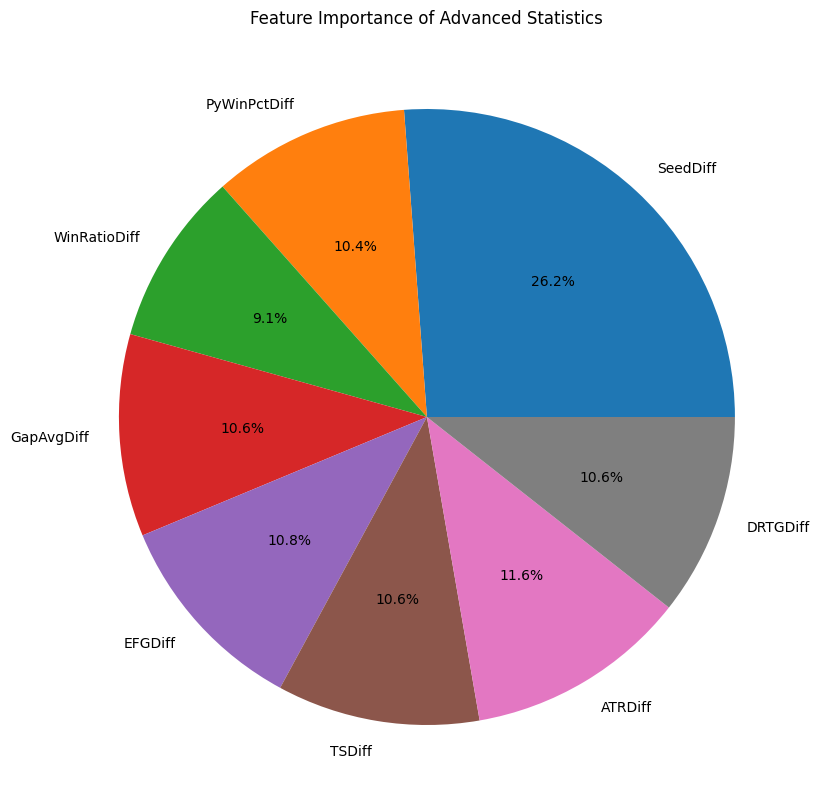

In [111]:
# pie chart of feature importance
plt.figure(figsize=(10, 10))
plt.pie(model.feature_importances_, labels=X.columns, autopct="%1.1f%%")
plt.title("Feature Importance of Advanced Statistics")
plt.show()